In [1]:
import os
import statistics
import polars as pl
import pandas as pd
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings("ignore")

# KPI

Vamos a utilizar el **MAE**. Para ello necesitamos obtener las variables:
-  `y_pred`: la predicción de la hora que llega el autobús que ofrece la API cuando se realiza la llamada
-  `y_true`: para cada autobús,linea, parada y destino concreto, la predicción que ofrece la API más fiable (entendiendose por fiable aquella que es inferior a 60 segundos).

Para obtener `y_true`, cogemos el valor de `y_pred` para los valores en los que `estimateArrive` sea inferior a 60 segundos de cada autobús, linea, parada y destino concretos


In [5]:
sample_data_02 = pl.scan_csv('/home/mlia/proyectos/data-generation/data/train/emt/2024/03/03/emt_20240303.csv')
sample_data_aux_02 = pl.scan_csv('/home/mlia/proyectos/data-generation/data/train/emt/2024/03/03/emt_20240303_aux.csv')

In [6]:
sample_data_02.head().collect()

,PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
i64,str,str,str,i64,str,i64,f64,f64,i64,str,f64,i64,str,i64
0,"""2024-03-03 22:…","""2024-03-03""","""2024-03-03 22:…",2331,"""127""",1617,-3.71898,40.465098,3645,"""CUATRO CAMINOS…",null,0,"""FE""",818
1,"""2024-03-03 10:…","""2024-03-03""","""2024-03-03 10:…",2133,"""107""",497,-3.688693,40.467328,2778,"""HORTALEZA""",15.0,0,"""FE""",555
2,"""2024-03-03 20:…","""2024-03-03""","""2024-03-03 20:…",541,"""70""",232,-3.675485,40.467472,6703,"""ALSACIA""",12.0,0,"""FE""",1369
3,"""2024-03-03 13:…","""2024-03-03""","""2024-03-03 13:…",2268,"""175""",4508,-3.696627,40.486987,13206,"""PLAZA CASTILLA…",20.0,1,"""FE""",2318
4,"""2024-03-03 15:…","""2024-03-03""","""2024-03-03 15:…",3273,"""11""",220,-3.669398,40.458809,8153,"""BARRIO BLANCO""",null,0,"""FE""",2399


In [7]:
sample_data_aux_02.head().collect()

,PK,reliable_arrival_date,predict_arrival_date,interval_time,estimateArrive
i64,str,str,str,str,i64
0,"""2024-03-03 13:…","""2024-03-03 13:…","""2024-03-03 14:…","""[12 14]""",2318
1,"""2024-03-03 15:…","""2024-03-03 15:…","""2024-03-03 16:…","""[14 16]""",2399
2,"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 13:…","""[11 13]""",2053
3,"""2024-03-03 13:…","""2024-03-03 13:…","""2024-03-03 13:…","""[12 14]""",56
4,"""2024-03-03 19:…","""2024-03-03 19:…","""2024-03-03 19:…","""[18 20]""",201


In [35]:
def KPI_fun(date_true,date_pred):
    date_true = datetime.strptime(date_true, '%Y-%m-%d %H:%M:%S.%f')
    date_pred = datetime.strptime(date_pred, '%Y-%m-%d %H:%M:%S.%f')
    
    dif = max(date_true,date_pred) - min(date_true,date_pred)
    return dif.total_seconds()

In [9]:
KPI_data = sample_data_aux_02.with_columns(pl.struct(pl.col('reliable_arrival_date'),pl.col('predict_arrival_date')).alias('struct').map_elements(lambda x: KPI_fun(x['reliable_arrival_date'], x['predict_arrival_date'])).alias('KPI_value')).collect()

In [10]:
dict_data = KPI_data.sort('estimateArrive').select('estimateArrive','KPI_value').to_dict()

In [11]:
dict_data2 = KPI_data.filter(pl.col('KPI_value')<500).sort('estimateArrive').select('estimateArrive','KPI_value').to_dict()

In [42]:
def plot_KPI(dict):
    new_dict = {}
    MAE = []
    for eta, kpi in zip(dict['estimateArrive'], dict['KPI_value']):
        # Verificar si el entero ya está en el diccionario
        if eta in new_dict:
            # Si el entero ya está en el diccionario, agregar el valor numérico a la lista existente
            new_dict[eta].append(kpi)
        else:
            # Si el entero no está en el diccionario, crear una nueva lista con el valor numérico
            new_dict[eta] = [kpi]
            
    for key,val in zip(new_dict.keys(),new_dict.values()):
        MAE.append((key/60,statistics.mean(val)/60))
        

    plt.plot([data[0] for data in MAE], [data[1] for data in MAE])
    plt.gca().invert_xaxis()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.title('CRTM API estimation error')
    plt.xlabel('Remaining time (minutes)')
    plt.ylabel('MAE (minutes)')
    plt.show()

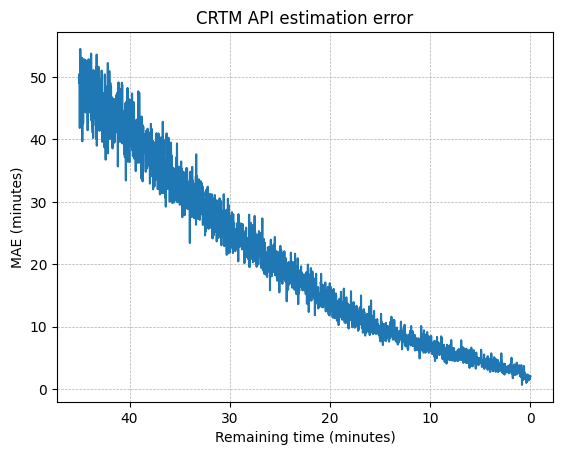

In [13]:
plot_KPI(dict_data)

In [14]:
#TODO: una posibilidad es filtrar por los que el KPI sea <500 segundos (aprox 8 minutos) para asi quitar los valores erroneos que hayan salido con la creacion del intervalo

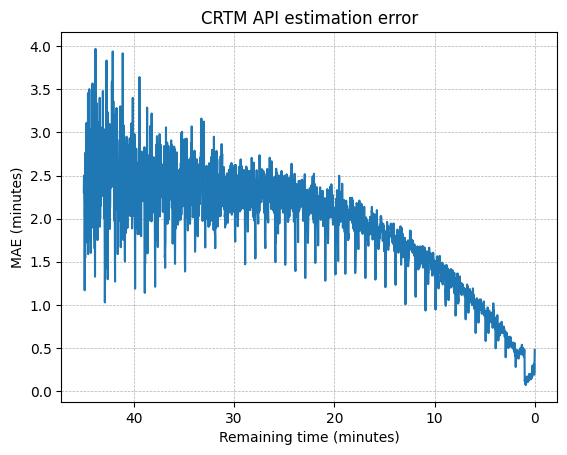

In [15]:
plot_KPI(dict_data2)

# Filtramos
* Bus 51
* Line BR1
* Stop 4366
* Destination VALDEBEBAS


In [16]:
sample_data_02 = sample_data_02.filter(pl.col('bus')==51, pl.col('line')=="BR1",pl.col('stop')==4366, pl.col('destination')=="VALDEBEBAS")

In [17]:
data = sample_data_aux_02.join(sample_data_02,on='PK',how='inner')

In [24]:
data.collect()

,PK,reliable_arrival_date,predict_arrival_date,interval_time,estimateArrive,_right,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive_right
i64,str,str,str,str,i64,i64,str,str,i64,str,i64,f64,f64,i64,str,f64,i64,str,i64
13333,"""2024-03-03 11:…","""2024-03-03 11:…","""2024-03-03 11:…","""[10 12]""",864,17814,"""2024-03-03""","""2024-03-03 11:…",51,"""BR1""",4366,-3.698413,40.490519,8045,"""VALDEBEBAS""",null,0,"""FE""",864
20709,"""2024-03-03 11:…","""2024-03-03 11:…","""2024-03-03 11:…","""[10 12]""",540,27536,"""2024-03-03""","""2024-03-03 11:…",51,"""BR1""",4366,-3.661998,40.498973,3287,"""VALDEBEBAS""",null,0,"""FE""",540
32386,"""2024-03-03 11:…","""2024-03-03 11:…","""2024-03-03 11:…","""[10 12]""",1250,43012,"""2024-03-03""","""2024-03-03 11:…",51,"""BR1""",4366,-3.692432,40.486629,10340,"""VALDEBEBAS""",null,0,"""FE""",1250
35941,"""2024-03-03 08:…","""2024-03-03 08:…","""2024-03-03 08:…","""[7 9]""",2044,47768,"""2024-03-03""","""2024-03-03 08:…",51,"""BR1""",4366,-3.641676,40.484641,18705,"""VALDEBEBAS""",null,0,"""FE""",2044
40658,"""2024-03-03 10:…","""2024-03-03 10:…","""2024-03-03 11:…","""[ 9 11]""",1410,54070,"""2024-03-03""","""2024-03-03 10:…",51,"""BR1""",4366,-3.67561,40.484079,12528,"""VALDEBEBAS""",null,0,"""FE""",1410
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
780200,"""2024-03-03 08:…","""2024-03-03 08:…","""2024-03-03 08:…","""[7 9]""",628,1037349,"""2024-03-03""","""2024-03-03 08:…",51,"""BR1""",4366,-3.676432,40.483876,6105,"""VALDEBEBAS""",null,0,"""FE""",628
786139,"""2024-03-03 10:…","""2024-03-03 10:…","""2024-03-03 10:…","""[ 9 11]""",168,1045276,"""2024-03-03""","""2024-03-03 10:…",51,"""BR1""",4366,-3.653508,40.487681,868,"""VALDEBEBAS""",null,0,"""FE""",168
797676,"""2024-03-03 08:…","""2024-03-03 08:…","""2024-03-03 08:…","""[7 9]""",0,1060661,"""2024-03-03""","""2024-03-03 08:…",51,"""BR1""",4366,-3.642333,40.484241,0,"""VALDEBEBAS""",null,0,"""FE""",0


In [27]:
sample_data_aux_02_filter = data.filter(pl.col('interval_time')=="[11 13]").select(pl.col('datetime'),pl.col('reliable_arrival_date'),pl.col('predict_arrival_date'),pl.col('estimateArrive')).sort('datetime','estimateArrive',descending=True).collect()

In [28]:
KPI_data = sample_data_aux_02_filter.with_columns(pl.struct(reliable_arrival_date = pl.col('reliable_arrival_date'), predict_arrival_date = pl.col('predict_arrival_date').alias('struct')).map_elements(lambda x: KPI_fun(x['reliable_arrival_date'], x['predict_arrival_date'])).alias('KPI_value'))

In [29]:
KPI_data.sort('KPI_value',descending=True) #TODO: tabla para la ppt 

datetime,reliable_arrival_date,predict_arrival_date,estimateArrive,KPI_value
str,str,str,i64,f64
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",1958,341.567779
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",1716,341.148263
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",1837,341.135457
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",1898,340.938425
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",2061,340.932139
…,…,…,…,…
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",175,0.396977
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",1180,0.389483
"""2024-03-03 12:…","""2024-03-03 12:…","""2024-03-03 12:…",1196,0.331104


In [25]:
dict = KPI_data.filter(pl.col('KPI_value')<500).sort('estimateArrive').select('estimateArrive','KPI_value')

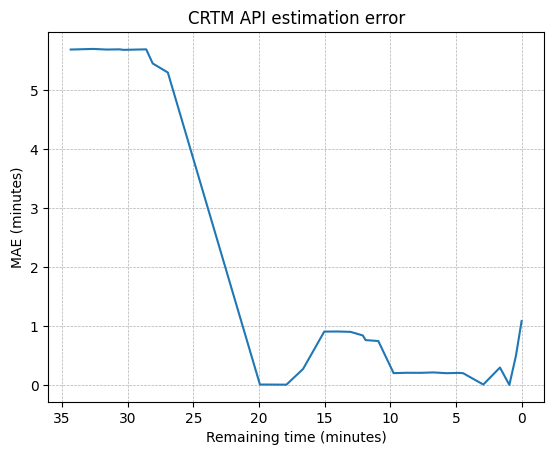

In [26]:
plot_KPI(dict) #TODO: gráfica para la ppt

# PRUEBA DEFINITIVA

## BUS,LINEA,PARADA DESTINO FIJOS

In [2]:
import os
import statistics
import random
import polars as pl
import pandas as pd
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings


In [3]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))
DATA_PATH = os.path.join(ROOT_PATH, "data", "processed")
EMT_DATA_PATH = os.path.join(DATA_PATH, "emt")

In [4]:
data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03", f"emt_202403.csv"))
list_day = ['02','03','04','05','06','07','08','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']

In [5]:
random.seed(1234)  
day = random.randint(2, 31)

print(day)

26


In [6]:
sample_data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03",str(day), f"emt_202403{str(day)}.csv"))

In [7]:
def create_final_dataset(sample_data):
    sample_data = sample_data.with_columns((pl.col('datetime').cast(pl.String)+"_B"+pl.col('bus').cast(pl.String)+"_L"+ pl.col('line').cast(pl.String)+"_S"+pl.col('stop').cast(pl.String)).alias('PK'))
    
    # ETA <2400
    sample_data = sample_data.filter(pl.col('estimateArrive')<888888)
    sample_data = sample_data.group_by('PK').min()
    
    sample_data = sample_data.with_columns(pl.col("date").cast(pl.Date),pl.col('bus').cast(pl.String),pl.col('line').cast(pl.String),pl.col('isHead').cast(pl.UInt8))
    
    sample_data = sample_data.with_columns(pl.col('datetime').map_elements(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")))
    
    # Rellenamos valores nulos de dayType
    sample_data = sample_data.with_columns(pl.when(pl.col('dayType').is_null()).then(pl.col('date').apply(get_type_day)).otherwise(pl.col('dayType')).alias('dayType'))
    
    # Eliminamos variables
    sample_data = sample_data.drop('positionTypeBus','deviation','MaximumFrequency','StartTime','StopTime','strike')
    
    return sample_data.collect()
    

In [8]:
def get_type_day(date):
    
    day = date.strftime("%A")
    
    if day in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
        
        type = 'LA'
    elif day == 'Saturday':
        type = 'SA'
    else:
        type = 'FE'
        
    return type

In [9]:
sample_data = create_final_dataset(sample_data)

In [10]:
sample_data

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
str,date,datetime[μs],str,str,i64,f64,f64,i64,str,i64,u8,str,i64
"""2024-03-26 21:…",2024-03-26,2024-03-26 21:40:09.739783,"""2536""","""170""",5399,-3.684673,40.511029,5665,"""SANCHINARRO""",null,0,"""LA""",967
"""2024-03-26 08:…",2024-03-26,2024-03-26 08:10:09.881904,"""9109""","""177""",5803,-3.688479,40.467095,1383,"""MARQUES DE VIA…",9,0,"""LA""",300
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:23:08.488793,"""2477""","""173""",5518,-3.664287,40.493674,1672,"""PLAZA CASTILLA…",7,1,"""LA""",590
"""2024-03-26 16:…",2024-03-26,2024-03-26 16:50:07.442667,"""2497""","""170""",2970,-3.701602,40.504168,9687,"""SANCHINARRO""",null,0,"""LA""",2178
"""2024-03-26 20:…",2024-03-26,2024-03-26 20:30:06.307634,"""3279""","""11""",222,-3.693661,40.459219,3559,"""BARRIO BLANCO""",null,0,"""LA""",1062
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-26 21:…",2024-03-26,2024-03-26 21:42:07.452901,"""4708""","""82""",1629,-3.727311,40.445077,6819,"""PITIS""",null,0,"""LA""",1068
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:13:08.297954,"""2477""","""173""",3603,-3.689128,40.468215,4298,"""SANCHINARRO""",7,0,"""LA""",499
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:46:11.429187,"""51""","""BR1""",5899,-3.63154,40.48568,505,"""VALDEBEBAS""",null,0,"""LA""",94


In [11]:
sample_data = sample_data.filter(pl.col('bus')=='51', pl.col('line')=="BR1",pl.col('stop')==4366, pl.col('destination')=="VALDEBEBAS").sort('datetime')

In [12]:
sample_data

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
str,date,datetime[μs],str,str,i64,f64,f64,i64,str,i64,u8,str,i64
"""2024-03-26 09:…",2024-03-26,2024-03-26 09:07:08.486404,"""51""","""BR1""",4366,-3.695309,40.486747,9195,"""VALDEBEBAS""",null,0,"""LA""",1536
"""2024-03-26 09:…",2024-03-26,2024-03-26 09:08:08.881899,"""51""","""BR1""",4366,-3.695309,40.486747,8836,"""VALDEBEBAS""",null,0,"""LA""",1476
"""2024-03-26 09:…",2024-03-26,2024-03-26 09:09:08.755131,"""51""","""BR1""",4366,-3.695309,40.486747,9226,"""VALDEBEBAS""",null,0,"""LA""",1381
"""2024-03-26 09:…",2024-03-26,2024-03-26 09:10:08.875354,"""51""","""BR1""",4366,-3.695309,40.486747,8825,"""VALDEBEBAS""",null,0,"""LA""",1321
"""2024-03-26 09:…",2024-03-26,2024-03-26 09:11:10.677695,"""51""","""BR1""",4366,-3.696617,40.48821,9028,"""VALDEBEBAS""",null,0,"""LA""",1239
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:39:07.409588,"""51""","""BR1""",4366,-3.658057,40.493668,1920,"""VALDEBEBAS""",null,0,"""LA""",339
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:40:08.462574,"""51""","""BR1""",4366,-3.659287,40.490522,1455,"""VALDEBEBAS""",null,0,"""LA""",263
"""2024-03-26 22:…",2024-03-26,2024-03-26 22:41:08.942691,"""51""","""BR1""",4366,-3.654665,40.488051,1123,"""VALDEBEBAS""",null,0,"""LA""",203


In [13]:
def calculate_predict_arrival_date(date_datetime,second):
    new_date_datetime = date_datetime + timedelta(seconds=second)
    
    return new_date_datetime

In [14]:
sample_data = sample_data.with_columns(pl.struct(datetime = pl.col('datetime'), estimateArrive = pl.col('estimateArrive').alias('struct')).map_elements(lambda x: calculate_predict_arrival_date(x['datetime'], x['estimateArrive'])).alias('predict_arrival_date'))

In [15]:
sample_data_pd = sample_data.to_pandas()
sample_data_pd['bloque_id'] = None

bloque_actual = 1
for i in range(0, len(sample_data_pd)-1):
    if (sample_data_pd['datetime'][i + 1] - sample_data_pd['datetime'][i]) > timedelta(minutes=5) and (sample_data_pd['estimateArrive'][i] < sample_data_pd['estimateArrive'][i + 1]):
        sample_data_pd['bloque_id'][i] = bloque_actual
        bloque_actual += 1
        
    else:
        sample_data_pd['bloque_id'][i] = bloque_actual

In [16]:
sample_data_pd.at[sample_data_pd.index[-1], 'bloque_id'] = bloque_actual

In [ ]:
sample_data_pd.head(20)

In [18]:
sample_data_pl = pl.from_pandas(sample_data_pd)

In [19]:
sample_data_pl.sort('bloque_id','estimateArrive',descending=True)

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive,predict_arrival_date,bloque_id
str,datetime[ms],datetime[μs],str,str,i64,f64,f64,i64,str,f64,u8,str,i64,datetime[μs],i64
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:05:08.146916,"""51""","""BR1""",4366,-3.625174,40.482623,19754,"""VALDEBEBAS""",null,0,"""LA""",2515,2024-03-26 22:47:03.146916,9
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:06:08.223862,"""51""","""BR1""",4366,-3.635248,40.486303,19275,"""VALDEBEBAS""",null,0,"""LA""",2454,2024-03-26 22:47:02.223862,9
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:07:07.950631,"""51""","""BR1""",4366,-3.643053,40.484473,18804,"""VALDEBEBAS""",null,0,"""LA""",2394,2024-03-26 22:47:01.950631,9
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:08:08.530312,"""51""","""BR1""",4366,-3.643053,40.484473,18286,"""VALDEBEBAS""",null,0,"""LA""",2328,2024-03-26 22:46:56.530312,9
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:09:08.167593,"""51""","""BR1""",4366,-3.643053,40.484473,17862,"""VALDEBEBAS""",null,0,"""LA""",2274,2024-03-26 22:47:02.167593,9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:23:08.256559,"""51""","""BR1""",4366,-3.659662,40.4922,1746,"""VALDEBEBAS""",null,0,"""LA""",321,2024-03-26 09:28:29.256559,1
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:24:08.643877,"""51""","""BR1""",4366,-3.658428,40.489981,1276,"""VALDEBEBAS""",null,0,"""LA""",232,2024-03-26 09:28:00.643877,1
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:25:09.036527,"""51""","""BR1""",4366,-3.655349,40.487956,847,"""VALDEBEBAS""",null,0,"""LA""",159,2024-03-26 09:27:48.036527,1


In [20]:
small_sample_data = sample_data_pl.filter(pl.col('estimateArrive')<=60).group_by(pl.col('bus'),pl.col('line'),pl.col('stop'),pl.col('destination'),pl.col('date'),pl.col('bloque_id')).min().with_columns(pl.col('predict_arrival_date').alias('reliable_arrival_date'))
small_sample_data

bus,line,stop,destination,date,bloque_id,PK,datetime,positionBusLon,positionBusLat,DistanceBus,MinimunFrequency,isHead,dayType,estimateArrive,predict_arrival_date,reliable_arrival_date
str,str,i64,str,datetime[ms],i64,str,datetime[μs],f64,f64,i64,f64,u8,str,i64,datetime[μs],datetime[μs]
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,4,"""2024-03-26 13:…",2024-03-26 13:42:09.058943,-3.649841,40.486513,202,null,0,"""LA""",28,2024-03-26 13:42:37.058943,2024-03-26 13:42:37.058943
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,3,"""2024-03-26 12:…",2024-03-26 12:15:09.310898,-3.646471,40.485319,0,null,0,"""LA""",0,2024-03-26 12:15:09.310898,2024-03-26 12:15:09.310898
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,7,"""2024-03-26 20:…",2024-03-26 20:00:08.897971,-3.647037,40.485411,214,null,0,"""LA""",33,2024-03-26 20:00:41.897971,2024-03-26 20:00:41.897971
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,8,"""2024-03-26 21:…",2024-03-26 21:22:09.062779,-3.647071,40.484471,0,null,0,"""LA""",0,2024-03-26 21:22:55.062779,2024-03-26 21:22:55.062779
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,6,"""2024-03-26 18:…",2024-03-26 18:31:10.487315,-3.643471,40.484603,0,null,0,"""LA""",0,2024-03-26 18:31:10.487315,2024-03-26 18:31:10.487315
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,1,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,2,"""2024-03-26 10:…",2024-03-26 10:49:07.411681,-3.644106,40.484726,0,null,0,"""LA""",0,2024-03-26 10:49:23.411681,2024-03-26 10:49:23.411681
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,9,"""2024-03-26 22:…",2024-03-26 22:43:10.564491,-3.645521,40.485224,236,null,0,"""LA""",39,2024-03-26 22:43:49.564491,2024-03-26 22:43:49.564491


In [21]:
small_sample_data = small_sample_data.filter(pl.col('bloque_id').is_not_null())

In [22]:
small_sample_data

bus,line,stop,destination,date,bloque_id,PK,datetime,positionBusLon,positionBusLat,DistanceBus,MinimunFrequency,isHead,dayType,estimateArrive,predict_arrival_date,reliable_arrival_date
str,str,i64,str,datetime[ms],i64,str,datetime[μs],f64,f64,i64,f64,u8,str,i64,datetime[μs],datetime[μs]
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,4,"""2024-03-26 13:…",2024-03-26 13:42:09.058943,-3.649841,40.486513,202,null,0,"""LA""",28,2024-03-26 13:42:37.058943,2024-03-26 13:42:37.058943
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,3,"""2024-03-26 12:…",2024-03-26 12:15:09.310898,-3.646471,40.485319,0,null,0,"""LA""",0,2024-03-26 12:15:09.310898,2024-03-26 12:15:09.310898
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,7,"""2024-03-26 20:…",2024-03-26 20:00:08.897971,-3.647037,40.485411,214,null,0,"""LA""",33,2024-03-26 20:00:41.897971,2024-03-26 20:00:41.897971
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,8,"""2024-03-26 21:…",2024-03-26 21:22:09.062779,-3.647071,40.484471,0,null,0,"""LA""",0,2024-03-26 21:22:55.062779,2024-03-26 21:22:55.062779
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,6,"""2024-03-26 18:…",2024-03-26 18:31:10.487315,-3.643471,40.484603,0,null,0,"""LA""",0,2024-03-26 18:31:10.487315,2024-03-26 18:31:10.487315
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,1,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,2,"""2024-03-26 10:…",2024-03-26 10:49:07.411681,-3.644106,40.484726,0,null,0,"""LA""",0,2024-03-26 10:49:23.411681,2024-03-26 10:49:23.411681
"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,9,"""2024-03-26 22:…",2024-03-26 22:43:10.564491,-3.645521,40.485224,236,null,0,"""LA""",39,2024-03-26 22:43:49.564491,2024-03-26 22:43:49.564491


In [23]:
final_sample_data = sample_data_pl.join(small_sample_data,on=pl.col('bloque_id'),how = 'left')

In [24]:
final_sample_data

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive,predict_arrival_date,bloque_id,bus_right,line_right,stop_right,destination_right,date_right,PK_right,datetime_right,positionBusLon_right,positionBusLat_right,DistanceBus_right,MinimunFrequency_right,isHead_right,dayType_right,estimateArrive_right,predict_arrival_date_right,reliable_arrival_date
str,datetime[ms],datetime[μs],str,str,i64,f64,f64,i64,str,f64,u8,str,i64,datetime[μs],i64,str,str,i64,str,datetime[ms],str,datetime[μs],f64,f64,i64,f64,u8,str,i64,datetime[μs],datetime[μs]
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:07:08.486404,"""51""","""BR1""",4366,-3.695309,40.486747,9195,"""VALDEBEBAS""",null,0,"""LA""",1536,2024-03-26 09:32:44.486404,1,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:08:08.881899,"""51""","""BR1""",4366,-3.695309,40.486747,8836,"""VALDEBEBAS""",null,0,"""LA""",1476,2024-03-26 09:32:44.881899,1,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:09:08.755131,"""51""","""BR1""",4366,-3.695309,40.486747,9226,"""VALDEBEBAS""",null,0,"""LA""",1381,2024-03-26 09:32:09.755131,1,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:10:08.875354,"""51""","""BR1""",4366,-3.695309,40.486747,8825,"""VALDEBEBAS""",null,0,"""LA""",1321,2024-03-26 09:32:09.875354,1,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
"""2024-03-26 09:…",2024-03-26 00:00:00,2024-03-26 09:11:10.677695,"""51""","""BR1""",4366,-3.696617,40.48821,9028,"""VALDEBEBAS""",null,0,"""LA""",1239,2024-03-26 09:31:49.677695,1,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 09:…",2024-03-26 09:27:08.674862,-3.643678,40.48467,0,null,0,"""LA""",0,2024-03-26 09:27:08.674862,2024-03-26 09:27:08.674862
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:39:07.409588,"""51""","""BR1""",4366,-3.658057,40.493668,1920,"""VALDEBEBAS""",null,0,"""LA""",339,2024-03-26 22:44:46.409588,9,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 22:…",2024-03-26 22:43:10.564491,-3.645521,40.485224,236,null,0,"""LA""",39,2024-03-26 22:43:49.564491,2024-03-26 22:43:49.564491
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:40:08.462574,"""51""","""BR1""",4366,-3.659287,40.490522,1455,"""VALDEBEBAS""",null,0,"""LA""",263,2024-03-26 22:44:31.462574,9,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 22:…",2024-03-26 22:43:10.564491,-3.645521,40.485224,236,null,0,"""LA""",39,2024-03-26 22:43:49.564491,2024-03-26 22:43:49.564491
"""2024-03-26 22:…",2024-03-26 00:00:00,2024-03-26 22:41:08.942691,"""51""","""BR1""",4366,-3.654665,40.488051,1123,"""VALDEBEBAS""",null,0,"""LA""",203,2024-03-26 22:44:31.942691,9,"""51""","""BR1""",4366,"""VALDEBEBAS""",2024-03-26 00:00:00,"""2024-03-26 22:…",2024-03-26 22:43:10.564491,-3.645521,40.485224,236,null,0,"""LA""",39,2024-03-26 22:43:49.564491,2024-03-26 22:43:49.564491


In [25]:
final_sample_data = final_sample_data.select(pl.col('PK'),pl.col('datetime'),pl.col('reliable_arrival_date'),pl.col('predict_arrival_date'),pl.col('bloque_id'),pl.col('estimateArrive'))

In [26]:
final_sample_data = final_sample_data.filter(pl.col('reliable_arrival_date').is_not_null())

In [27]:
final_sample_data.to_pandas().head(20)

,PK,datetime,reliable_arrival_date,predict_arrival_date,bloque_id,estimateArrive
0,2024-03-26 09:07:08.486404_B51_LBR1_S4366,2024-03-26 09:07:08.486404,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.486404,1,1536
1,2024-03-26 09:08:08.881899_B51_LBR1_S4366,2024-03-26 09:08:08.881899,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.881899,1,1476
2,2024-03-26 09:09:08.755131_B51_LBR1_S4366,2024-03-26 09:09:08.755131,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.755131,1,1381
3,2024-03-26 09:10:08.875354_B51_LBR1_S4366,2024-03-26 09:10:08.875354,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.875354,1,1321
4,2024-03-26 09:11:10.677695_B51_LBR1_S4366,2024-03-26 09:11:10.677695,2024-03-26 09:27:08.674862,2024-03-26 09:31:49.677695,1,1239
5,2024-03-26 09:12:08.822076_B51_LBR1_S4366,2024-03-26 09:12:08.822076,2024-03-26 09:27:08.674862,2024-03-26 09:31:53.822076,1,1185
6,2024-03-26 09:13:09.160954_B51_LBR1_S4366,2024-03-26 09:13:09.160954,2024-03-26 09:27:08.674862,2024-03-26 09:30:28.160954,1,1039
7,2024-03-26 09:14:08.414499_B51_LBR1_S4366,2024-03-26 09:14:08.414499,2024-03-26 09:27:08.674862,2024-03-26 09:30:00.414499,1,952
8,2024-03-26 09:15:09.979541_B51_LBR1_S4366,2024-03-26 09:15:09.979541,2024-03-26 09:27:08.674862,2024-03-26 09:29:15.979541,1,846
9,2024-03-26 09:17:07.807332_B51_LBR1_S4366,2024-03-26 09:17:07.807332,2024-03-26 09:27:08.674862,2024-03-26 09:28:29.807332,1,682


In [28]:
def KPI_fun(date_true,date_pred):
    #date_true = datetime.strptime(date_true, '%Y-%m-%d %H:%M:%S.%f')
    #date_pred = datetime.strptime(date_pred, '%Y-%m-%d %H:%M:%S.%f')
    
    dif = max(date_true,date_pred) - min(date_true,date_pred)
    return dif.total_seconds()

In [29]:
KPI_data = final_sample_data.with_columns(pl.struct(pl.col('reliable_arrival_date'),pl.col('predict_arrival_date')).alias('struct').map_elements(lambda x: KPI_fun(x['reliable_arrival_date'], x['predict_arrival_date'])).alias('KPI_value'))

In [30]:
KPI_data.head(35)

PK,datetime,reliable_arrival_date,predict_arrival_date,bloque_id,estimateArrive,KPI_value
str,datetime[μs],datetime[μs],datetime[μs],i64,i64,f64
"""2024-03-26 09:…",2024-03-26 09:07:08.486404,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.486404,1,1536,335.811542
"""2024-03-26 09:…",2024-03-26 09:08:08.881899,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.881899,1,1476,336.207037
"""2024-03-26 09:…",2024-03-26 09:09:08.755131,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.755131,1,1381,301.080269
"""2024-03-26 09:…",2024-03-26 09:10:08.875354,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.875354,1,1321,301.200492
"""2024-03-26 09:…",2024-03-26 09:11:10.677695,2024-03-26 09:27:08.674862,2024-03-26 09:31:49.677695,1,1239,281.002833
…,…,…,…,…,…,…
"""2024-03-26 10:…",2024-03-26 10:41:08.947750,2024-03-26 10:49:23.411681,2024-03-26 10:52:36.947750,2,688,193.536069
"""2024-03-26 10:…",2024-03-26 10:43:08.450481,2024-03-26 10:49:23.411681,2024-03-26 10:51:55.450481,2,527,152.0388
"""2024-03-26 10:…",2024-03-26 10:44:08.198504,2024-03-26 10:49:23.411681,2024-03-26 10:51:56.198504,2,468,152.786823


In [31]:
a = KPI_data.to_pandas()[['estimateArrive','KPI_value','reliable_arrival_date','predict_arrival_date','datetime']]

In [32]:
a = KPI_data.to_pandas().iloc[0:19][['estimateArrive','KPI_value','reliable_arrival_date','predict_arrival_date','datetime']]

In [34]:
a['reliable_estimateArrive'] = a['reliable_arrival_date'] - a['datetime']
a['reliable_estimateArrive'] = abs(pd.to_timedelta(a['reliable_estimateArrive']).dt.total_seconds())

In [35]:
a

,estimateArrive,KPI_value,reliable_arrival_date,predict_arrival_date,datetime,reliable_estimateArrive
0,1536,335.811542,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.486404,2024-03-26 09:07:08.486404,1200.188458
1,1476,336.207037,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.881899,2024-03-26 09:08:08.881899,1139.792963
2,1381,301.080269,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.755131,2024-03-26 09:09:08.755131,1079.919731
3,1321,301.200492,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.875354,2024-03-26 09:10:08.875354,1019.799508
4,1239,281.002833,2024-03-26 09:27:08.674862,2024-03-26 09:31:49.677695,2024-03-26 09:11:10.677695,957.997167
5,1185,285.147214,2024-03-26 09:27:08.674862,2024-03-26 09:31:53.822076,2024-03-26 09:12:08.822076,899.852786
6,1039,199.486092,2024-03-26 09:27:08.674862,2024-03-26 09:30:28.160954,2024-03-26 09:13:09.160954,839.513908
7,952,171.739637,2024-03-26 09:27:08.674862,2024-03-26 09:30:00.414499,2024-03-26 09:14:08.414499,780.260363
8,846,127.304679,2024-03-26 09:27:08.674862,2024-03-26 09:29:15.979541,2024-03-26 09:15:09.979541,718.695321
9,682,81.132470,2024-03-26 09:27:08.674862,2024-03-26 09:28:29.807332,2024-03-26 09:17:07.807332,600.867530


In [36]:
a['MAPE'] = 100*abs((a['estimateArrive'] - a['reliable_estimateArrive'])/a['reliable_estimateArrive'])
a

,estimateArrive,KPI_value,reliable_arrival_date,predict_arrival_date,datetime,reliable_estimateArrive,MAPE
0,1536,335.811542,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.486404,2024-03-26 09:07:08.486404,1200.188458,27.979901
1,1476,336.207037,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.881899,2024-03-26 09:08:08.881899,1139.792963,29.497202
2,1381,301.080269,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.755131,2024-03-26 09:09:08.755131,1079.919731,27.879875
3,1321,301.200492,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.875354,2024-03-26 09:10:08.875354,1019.799508,29.535265
4,1239,281.002833,2024-03-26 09:27:08.674862,2024-03-26 09:31:49.677695,2024-03-26 09:11:10.677695,957.997167,29.332324
5,1185,285.147214,2024-03-26 09:27:08.674862,2024-03-26 09:31:53.822076,2024-03-26 09:12:08.822076,899.852786,31.688207
6,1039,199.486092,2024-03-26 09:27:08.674862,2024-03-26 09:30:28.160954,2024-03-26 09:13:09.160954,839.513908,23.762095
7,952,171.739637,2024-03-26 09:27:08.674862,2024-03-26 09:30:00.414499,2024-03-26 09:14:08.414499,780.260363,22.010555
8,846,127.304679,2024-03-26 09:27:08.674862,2024-03-26 09:29:15.979541,2024-03-26 09:15:09.979541,718.695321,17.713303
9,682,81.132470,2024-03-26 09:27:08.674862,2024-03-26 09:28:29.807332,2024-03-26 09:17:07.807332,600.867530,13.502555


In [37]:
a['MAPE2'] = 100*abs((a['estimateArrive'] - a['reliable_estimateArrive'])/a[['reliable_estimateArrive','estimateArrive']].max(axis=1))

In [38]:
a.head(50)

,estimateArrive,KPI_value,reliable_arrival_date,predict_arrival_date,datetime,reliable_estimateArrive,MAPE,MAPE2
0,1536,335.811542,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.486404,2024-03-26 09:07:08.486404,1200.188458,27.979901,21.862731
1,1476,336.207037,2024-03-26 09:27:08.674862,2024-03-26 09:32:44.881899,2024-03-26 09:08:08.881899,1139.792963,29.497202,22.778255
2,1381,301.080269,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.755131,2024-03-26 09:09:08.755131,1079.919731,27.879875,21.801613
3,1321,301.200492,2024-03-26 09:27:08.674862,2024-03-26 09:32:09.875354,2024-03-26 09:10:08.875354,1019.799508,29.535265,22.800946
4,1239,281.002833,2024-03-26 09:27:08.674862,2024-03-26 09:31:49.677695,2024-03-26 09:11:10.677695,957.997167,29.332324,22.679809
5,1185,285.147214,2024-03-26 09:27:08.674862,2024-03-26 09:31:53.822076,2024-03-26 09:12:08.822076,899.852786,31.688207,24.063056
6,1039,199.486092,2024-03-26 09:27:08.674862,2024-03-26 09:30:28.160954,2024-03-26 09:13:09.160954,839.513908,23.762095,19.199816
7,952,171.739637,2024-03-26 09:27:08.674862,2024-03-26 09:30:00.414499,2024-03-26 09:14:08.414499,780.260363,22.010555,18.039878
8,846,127.304679,2024-03-26 09:27:08.674862,2024-03-26 09:29:15.979541,2024-03-26 09:15:09.979541,718.695321,17.713303,15.047834
9,682,81.132470,2024-03-26 09:27:08.674862,2024-03-26 09:28:29.807332,2024-03-26 09:17:07.807332,600.867530,13.502555,11.896257


In [39]:
resultados_MAE = a.groupby('estimateArrive')['KPI_value'].mean()

In [40]:
resultados_MAPE = a.groupby('estimateArrive')['MAPE2'].mean()

In [41]:
new_dict_MAPE = resultados_MAPE.to_dict()
new_dict_MAPE

{0: nan,
 100: 39.582948,
 159: 24.755764150943396,
 232: 22.400437500000006,
 321: 25.103332398753892,
 381: 21.27925380577428,
 500: 15.926808000000007,
 560: 14.391072678571431,
 620: 13.00291080645162,
 682: 11.89625659824047,
 846: 15.047834397163115,
 952: 18.039877836134455,
 1039: 19.199816361886427,
 1185: 24.06305603375527,
 1239: 22.679808958837775,
 1321: 22.800945647236944,
 1381: 21.80161252715424,
 1476: 22.778254539295386,
 1536: 21.862730598958326}

In [42]:
new_dict_MAE = resultados_MAE.to_dict()
new_dict_MAE

{0: 0.0,
 100: 39.582948,
 159: 39.361665,
 232: 51.969015,
 321: 80.581697,
 381: 81.073957,
 500: 79.63404,
 560: 80.590007,
 620: 80.618047,
 682: 81.13247,
 846: 127.304679,
 952: 171.739637,
 1039: 199.486092,
 1185: 285.147214,
 1239: 281.002833,
 1321: 301.200492,
 1381: 301.080269,
 1476: 336.207037,
 1536: 335.811542}

In [43]:
MAE = []
for key in new_dict_MAE.keys():
    MAE.append((key/60,new_dict_MAE[key]/60))

MAE

[(0.0, 0.0),
 (1.6666666666666667, 0.6597158000000001),
 (2.65, 0.65602775),
 (3.8666666666666667, 0.86615025),
 (5.35, 1.3430282833333334),
 (6.35, 1.3512326166666666),
 (8.333333333333334, 1.327234),
 (9.333333333333334, 1.3431667833333334),
 (10.333333333333334, 1.3436341166666668),
 (11.366666666666667, 1.3522078333333334),
 (14.1, 2.1217446499999997),
 (15.866666666666667, 2.8623272833333333),
 (17.316666666666666, 3.3247682000000003),
 (19.75, 4.752453566666667),
 (20.65, 4.68338055),
 (22.016666666666666, 5.0200082),
 (23.016666666666666, 5.018004483333333),
 (24.6, 5.603450616666667),
 (25.6, 5.596859033333333)]

In [44]:
MAPE = []
for key in new_dict_MAPE.keys():
    MAPE.append((key/60,new_dict_MAPE[key]))

MAPE

[(0.0, nan),
 (1.6666666666666667, 39.582948),
 (2.65, 24.755764150943396),
 (3.8666666666666667, 22.400437500000006),
 (5.35, 25.103332398753892),
 (6.35, 21.27925380577428),
 (8.333333333333334, 15.926808000000007),
 (9.333333333333334, 14.391072678571431),
 (10.333333333333334, 13.00291080645162),
 (11.366666666666667, 11.89625659824047),
 (14.1, 15.047834397163115),
 (15.866666666666667, 18.039877836134455),
 (17.316666666666666, 19.199816361886427),
 (19.75, 24.06305603375527),
 (20.65, 22.679808958837775),
 (22.016666666666666, 22.800945647236944),
 (23.016666666666666, 21.80161252715424),
 (24.6, 22.778254539295386),
 (25.6, 21.862730598958326)]

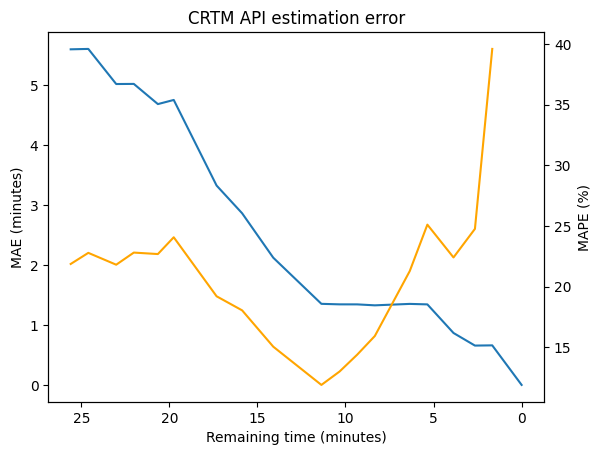

In [45]:
fig, ax1 = plt.subplots()

# Dibujar el primer gráfico con eje y a la izquierda
ax1.plot([data[0] for data in MAE], [data[1] for data in MAE])
ax1.set_xlabel('Remaining time (minutes)')
ax1.set_ylabel('MAE (minutes)')

ax2 = ax1.twinx()
ax2.plot([data[0] for data in MAPE], [data[1] for data in MAPE], 'orange')
ax2.set_ylabel('MAPE (%)')

plt.title('CRTM API estimation error')
plt.gca().invert_xaxis()


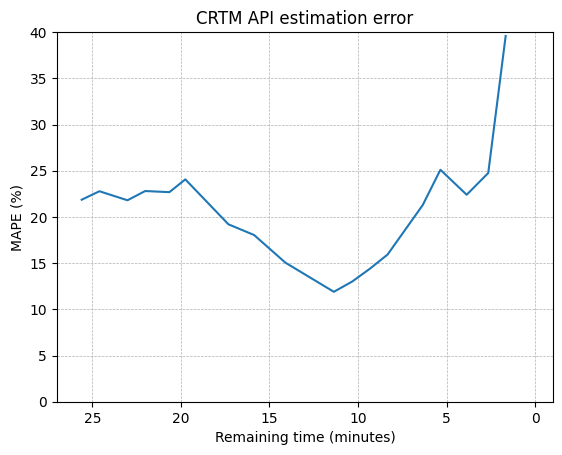

In [48]:
plt.plot([data[0] for data in MAPE], [data[1] for data in MAPE])
plt.ylim(0,40)
plt.xlim(-1,27)
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.title('CRTM API estimation error')
plt.xlabel('Remaining time (minutes)')
plt.ylabel('MAPE (%)')
plt.show()

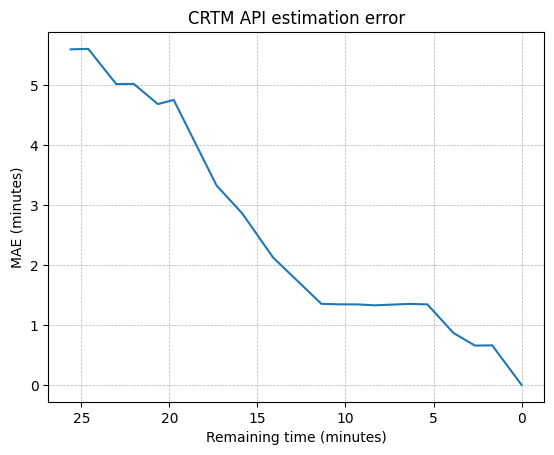

In [162]:
plt.plot([data[0] for data in MAE], [data[1] for data in MAE])
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.title('CRTM API estimation error')
plt.xlabel('Remaining time (minutes)')
plt.ylabel('MAE (minutes)')
plt.show()

In [44]:
dict = KPI_data.sort('estimateArrive').select('estimateArrive','KPI_value').to_dict()

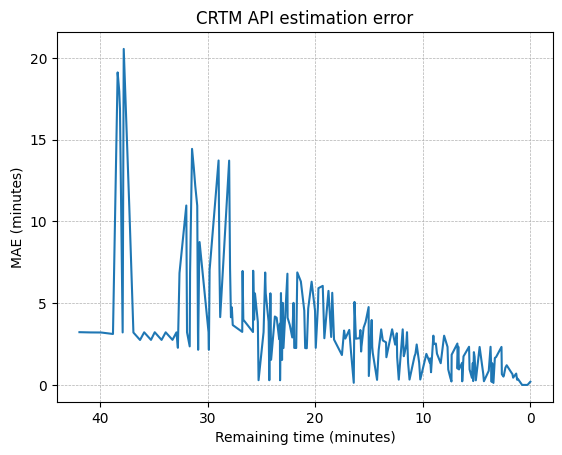

In [45]:
plot_KPI(dict)

## Para un día generalizando lo anterior

In [239]:
sample_data

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
str,date,datetime[μs],str,str,i64,f64,f64,i64,str,i64,u8,str,i64
"""2024-03-26 19:…",2024-03-26,2024-03-26 19:04:07.830005,"""2592""","""178""",1487,-3.697154,40.487528,2377,"""MONTECARMELO""",6,0,"""LA""",729
"""2024-03-26 11:…",2024-03-26,2024-03-26 11:13:06.952057,"""8828""","""9""",218,-3.649361,40.472321,1724,"""SOL SEVILLA""",null,0,"""LA""",496
"""2024-03-26 13:…",2024-03-26,2024-03-26 13:39:08.711052,"""2515""","""175""",3769,-3.696384,40.487048,6472,"""LAS TABLAS NOR…",9,0,"""LA""",918
"""2024-03-26 13:…",2024-03-26,2024-03-26 13:41:09.490335,"""8831""","""171""",5911,-3.631982,40.468928,4366,"""VALDEBEBAS""",null,0,"""LA""",1159
"""2024-03-26 16:…",2024-03-26,2024-03-26 16:30:07.126711,"""8857""","""176""",3261,-3.687647,40.470278,3590,"""LAS TABLAS SUR…",6,0,"""LA""",375
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-26 19:…",2024-03-26,2024-03-26 19:44:09.474926,"""4737""","""49""",5329,-3.704893,40.47915,281,"""PITIS""",4,0,"""LA""",137
"""2024-03-26 14:…",2024-03-26,2024-03-26 14:26:08.037914,"""2078""","""174""",3256,-3.685166,40.466831,4128,"""VALDEBEBAS""",7,0,"""LA""",922
"""2024-03-26 09:…",2024-03-26,2024-03-26 09:05:08.090547,"""8856""","""176""",2653,-3.688789,40.467426,1094,"""LAS TABLAS SUR…",6,0,"""LA""",553


In [230]:
sample_data_02 = sample_data.group_by(pl.col('bus'),pl.col('line'),pl.col('stop'),pl.col('destination')).count()

In [231]:
sample_data_02

bus,line,stop,destination,count
str,str,i64,str,u32
"""5726""","""147""",29,"""BARRIO DEL PIL…",114
"""8835""","""171""",5892,"""VALDEBEBAS""",29
"""2550""","""150""",60,"""VIRGEN CORTIJO…",123
"""2298""","""29""",214,"""MANOTERAS""",171
"""4796""","""45""",66,"""REINA VICTORIA…",207
…,…,…,…,…
"""577""","""70""",5603,"""ALSACIA""",119
"""4794""","""45""",60,"""REINA VICTORIA…",65
"""4836""","""132""",1364,"""HOSPITAL LA PA…",108


In [232]:
sample_data_pd = sample_data_02.to_pandas()

In [233]:
sample_data_pd

,bus,line,stop,destination,count
0,5726,147,29,BARRIO DEL PILAR,114
1,8835,171,5892,VALDEBEBAS,29
2,2550,150,60,VIRGEN CORTIJO,123
3,2298,29,214,MANOTERAS,171
4,4796,45,66,REINA VICTORIA,207
...,...,...,...,...,...
7908,577,70,5603,ALSACIA,119
7909,4794,45,60,REINA VICTORIA,65
7910,4836,132,1364,HOSPITAL LA PAZ,108
7911,539,70,212,ALSACIA,185


In [ ]:
for index,row in sample_data_pd.iterrows():
    print(type(str(row[1])))
    dataset_aux =  sample_data.filter(pl.col('bus')==str(row[0]), pl.col('line')==str(row[1]),pl.col('stop')==int(row[2]), pl.col('destination')==str(row[3]))
    print(dataset_aux.head())


# FUNCION 
Dado un bus, linea, parada y destino fijos, obtenemos el dataset con la PK, HORA PREDICHA, HORA EXACTA 

In [ ]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))
DATA_PATH = os.path.join(ROOT_PATH, "data", "processed")
EMT_DATA_PATH = os.path.join(DATA_PATH, "emt")

In [ ]:
data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03", f"emt_202403.csv"))
list_day = ['02','03','04','05','06','07','08','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']

In [ ]:
random.seed(1234)  
day = random.randint(2, 31)

print(day)

In [ ]:
sample_data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03",str(day), f"emt_202403{str(day)}.csv"))

In [ ]:
def create_final_dataset(sample_data):
    sample_data = sample_data.with_columns((pl.col('datetime').cast(pl.String)+"_B"+pl.col('bus').cast(pl.String)+"_L"+ pl.col('line').cast(pl.String)+"_S"+pl.col('stop').cast(pl.String)).alias('PK'))
    
    # ETA <2400
    sample_data = sample_data.filter(pl.col('estimateArrive')<888888)
    sample_data = sample_data.group_by('PK').min()
    
    sample_data = sample_data.with_columns(pl.col("date").cast(pl.Date),pl.col('line').cast(pl.String),pl.col('isHead').cast(pl.UInt8))
    
    sample_data = sample_data.with_columns(pl.col('datetime').map_elements(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")))
    
    # Rellenamos valores nulos de dayType
    sample_data = sample_data.with_columns(pl.when(pl.col('dayType').is_null()).then(pl.col('date').apply(get_type_day)).otherwise(pl.col('dayType')).alias('dayType'))
    
    # Eliminamos variables
    sample_data = sample_data.drop('positionTypeBus','deviation','MaximumFrequency','StartTime','StopTime','strike')
    
    return sample_data.collect()

In [ ]:
def get_type_day(date):
    
    day = date.strftime("%A")
    
    if day in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
        
        type = 'LA'
    elif day == 'Saturday':
        type = 'SA'
    else:
        type = 'FE'
        
    return type

In [ ]:
sample_data = create_final_dataset(sample_data)

In [1]:
def calculate_predict_arrival_date(date_datetime,second):
    new_date_datetime = date_datetime + timedelta(seconds=second)
    
    return new_date_datetime

In [2]:
def create_auxiliar_dataset(filter_data):
    # Creamos la hora predicha
    filter_data = filter_data.with_columns(pl.struct(datetime = pl.col('datetime'), estimateArrive = pl.col('estimateArrive').alias('struct')).map_elements(lambda x: calculate_predict_arrival_date(x['datetime'], x['estimateArrive'])).alias('predict_arrival_date'))
    
    # Creamos los bloques
    sample_data_pd = filter_data.to_pandas()
    sample_data_pd['bloque_id'] = None

    bloque_actual = 1
    for i in range(0, len(sample_data_pd)-1):
        if (sample_data_pd['datetime'][i + 1] - sample_data_pd['datetime'][i]) > timedelta(minutes=5) and (sample_data_pd['estimateArrive'][i] < sample_data_pd['estimateArrive'][i + 1]):
            sample_data_pd['bloque_id'][i] = bloque_actual
            bloque_actual += 1
            
        else: 
            sample_data_pd['bloque_id'][i] = bloque_actual
            
    sample_data_pd.at[sample_data_pd.index[-1], 'bloque_id'] = bloque_actual
    
    # Cremos el dataset exacto
    sample_data_pl = pl.from_pandas(sample_data_pd)
    small_sample_data = sample_data_pl.filter(pl.col('estimateArrive')<=60).group_by(pl.col('bus'),pl.col('line'),pl.col('stop'),pl.col('destination'),pl.col('date'),pl.col('bloque_id')).min().with_columns(pl.col('predict_arrival_date').alias('reliable_arrival_date'))   
    
    final_sample_data = sample_data_pl.join(small_sample_data,on=pl.col('bloque_id'),how = 'left') 
    final_sample_data = final_sample_data.select(pl.col('PK'),pl.col('reliable_arrival_date'),pl.col('predict_arrival_date'),pl.col('bloque_id'),pl.col('estimateArrive'))
    
    return final_sample_data